In [ ]:
!pip install av
!pip install moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 22.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torchvision.datasets import UCF101
from torchvision.io import read_video
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
#https://github.com/trudramukerji14/video_mae_mask/raw/refs/heads/main/data/UCF-OneVideo.zip
!wget https://github.com/trudramukerji14/video_mae_mask/raw/refs/heads/main/data/UCF-OneVideo.zip

--2025-08-14 15:54:56--  https://github.com/trudramukerji14/video_mae_mask/raw/refs/heads/main/data/UCF-OneVideo.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trudramukerji14/video_mae_mask/refs/heads/main/data/UCF-OneVideo.zip [following]
--2025-08-14 15:54:56--  https://raw.githubusercontent.com/trudramukerji14/video_mae_mask/refs/heads/main/data/UCF-OneVideo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278543 (272K) [application/zip]
Saving to: ‘UCF-OneVideo.zip’

UCF-OneVideo.zip    100%[===================>] 272.01K  --.-KB/s    in 0.02s   

2025-08-14 15:54:56 (12.1 MB/s) - ‘U

In [ ]:
import os
import zipfile

# After running the wget command, the file will be in the /content/ directory
path_to_zip_file = '/content/UCF-OneVideo.zip'

# This part is identical to your original code
directory_to_extract_to = '/content/extracted_files/'
os.makedirs(directory_to_extract_to, exist_ok=True)

# Now, unzip the file using the updated path
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
root_path = '/content/extracted_files/UCF-One Video/OneVideo'
annot_path = '/content/extracted_files/UCF-One Video/Annotation'
video_path = '/content/extracted_files/UCF-One Video/OneVideo/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'

#Strided Sampling:

A challenge in the pixel-reconstruction is **temporal redundancy** where consecutive frames often contain a great deal of redundant information allowing the model to "cheat" by looking at nearby frames.

VideoMAE masking method addresed this issue by implementing *strided sampling* where we sample $T$ frames from an original video of $N$ frames. The method does this by a stride $\tau$ where we sample every $\tau$th frame. For example, a ten-second clip with 25-30 frames per second with consist  

This allows us to reduce computational load while maintaining a non-trivial reconstruction task.

The VideoMAEClipProcessor class below implements this strided sampling which gets used within the dataset class for our single clip from UCF101.

In [ ]:
class CustomUCF101ForVideoMAE(UCF101):
    def __init__(self, root, annotation_path, frames_per_clip, step_between_clips,
                 fold, train, video_mae_processor):
        super().__init__(root, annotation_path, frames_per_clip, step_between_clips,
                         fold=fold, train=train, transform=None, output_format = 'TCHW') # No transform here
        self.video_mae_processor = video_mae_processor

    def __getitem__(self, idx):
        # This retrieves a clip of `frames_per_clip` length from UCF101
        video, audio, label = super().__getitem__(idx)
        # Apply the VideoMAE specific strided sampling and transforms
        processed_video = self.video_mae_processor(video)
        return processed_video, label # Return video and label, ignore audio for VideoMAE


class VideoMAEClipProcessor(torch.nn.Module):
    def __init__(self, num_frames, stride, transform=None):
        super().__init__()
        self.num_frames = num_frames
        self.stride = stride
        self.transform = transform

    def forward(self, video_tensor):
        # video_tensor from UCF101 is (T_base, C, H, W)
        # where T_base is frames_per_clip from UCF101 init (e.g., 64)
        total_frames_in_segment = video_tensor.shape[0]
        clip_span = self.stride * (self.num_frames - 1) + 1

        if total_frames_in_segment < clip_span:
            # Handle cases where the base UCF101 clip is too short for your sampling.
            # This should ideally not happen if frames_per_clip is set large enough.
            raise ValueError(f"UCF101 segment ({total_frames_in_segment} frames) is too short "
                             f"for VideoMAE sampling ({self.num_frames} frames, stride {self.stride}). "
                             f"Needs at least {clip_span} frames.")

        # In training, randomly choose a starting point for more data augmentation.
        # This will find all possible start frames within the current 64-frame segment.
        possible_start_frames = list(range(0, total_frames_in_segment - clip_span + 1, 1))

        if not possible_start_frames:
            raise ValueError("No valid starting frames for VideoMAE clip in this segment.")

        # Randomly choose one starting point
        clip_start_frame = possible_start_frames[torch.randint(len(possible_start_frames), (1,)).item()]

        # Slice the frames using the stride
        sampled_clip = video_tensor[clip_start_frame : clip_start_frame + self.stride * self.num_frames : self.stride]

        if self.transform:
            sampled_clip = self.transform(sampled_clip)

        return sampled_clip

In [ ]:
from torchvision import transforms

# Define the final spatial/value transforms for VideoMAE input
final_video_mae_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Standard input size for many models
    transforms.Lambda(lambda x: x / 255.0), # Normalize pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Create an instance of the VideoMAE processor
video_mae_processor = VideoMAEClipProcessor(
    num_frames=16,  # T frames for VideoMAE input
    stride=4,       # Temporal stride for VideoMAE
    transform=final_video_mae_transform
)


In [ ]:
#for reasons specific to the UCF Dataset class, we need to rename the annotation file
!mv "/content/extracted_files/UCF-One Video/Annotation/annotation.txt" "/content/extracted_files/UCF-One Video/Annotation/trainlist01.txt"


We now load the single

In [ ]:
#Initialize wrapped dataset
ucf_dataset_for_mae = CustomUCF101ForVideoMAE(
    root=root_path,
    annotation_path= annot_path,
    frames_per_clip=64,  # Load a segment long enough for strided sampling
    step_between_clips=100000, # Get first 64 clip, the paper actually picked a random consecutive block
    fold=1, # Choose a fold (1, 2, or 3)
    train=True,
    video_mae_processor=video_mae_processor
)

100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


So ignoring batch-size, we view our 16 frames as a $16 \times 3 \times 224 \times 224$ tensor. We split these frames into $2 \times 16 \times 16$ tokens, this gives us $8 \times 14 \times 14$ positions for the $2 \times 16 \times 16$  since  $224/16 = 14$ and $16/2 = 8$.

In [ ]:
data_loader = DataLoader(ucf_dataset_for_mae, batch_size = 1)
clip, label = next(iter(data_loader))
clip = clip.squeeze(0) #remove the batch dimension: get first batch
print(clip.shape)
print(clip[0].shape)

torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])


#Visualization before Masking

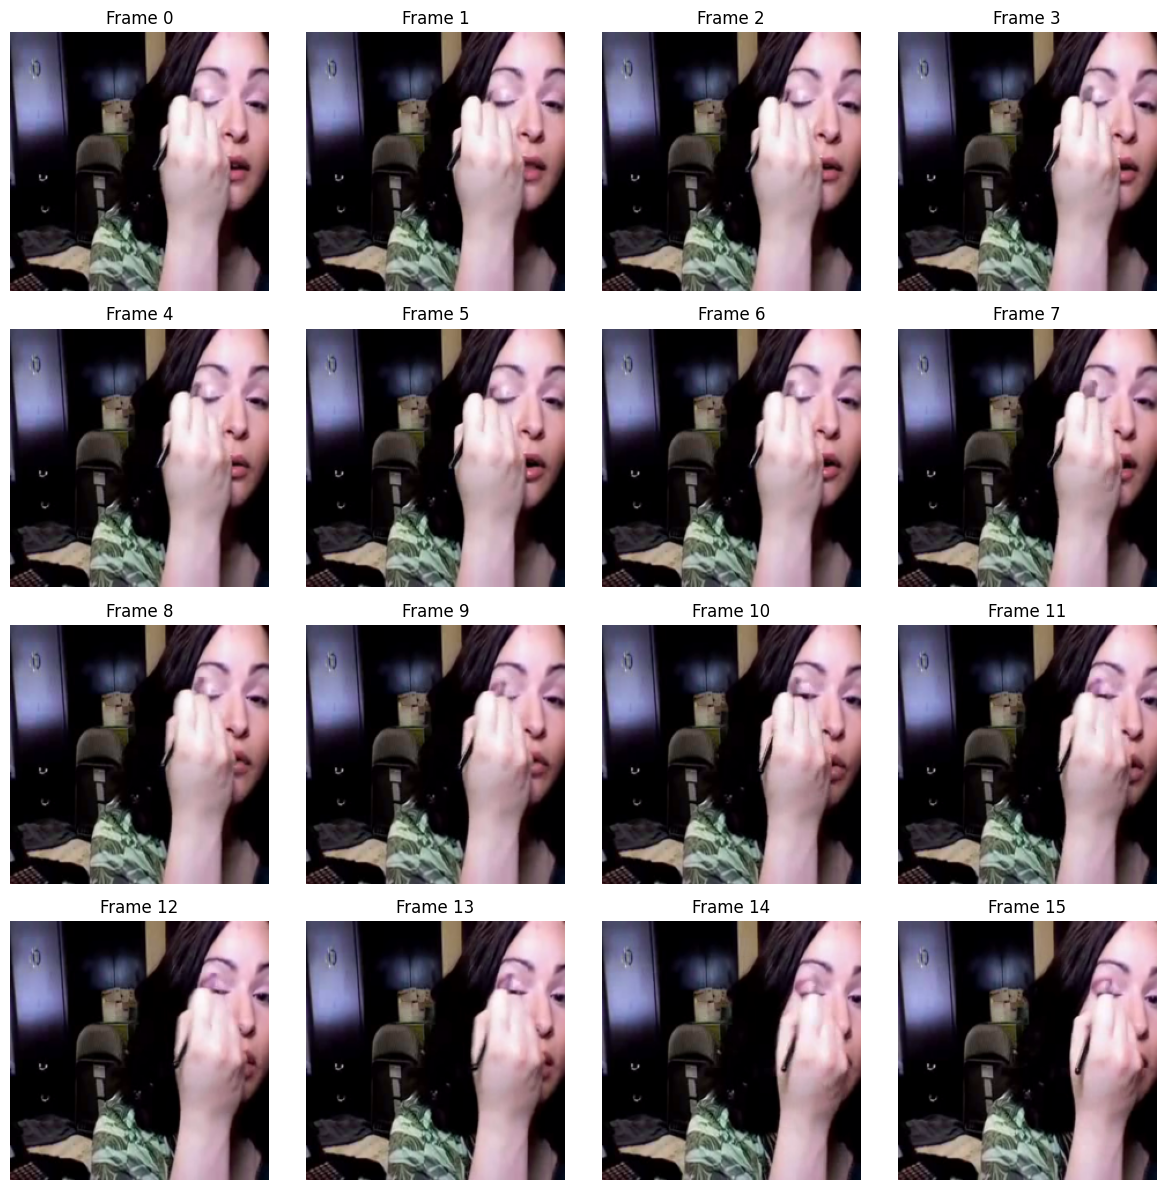

In [ ]:
#We can visualize the 16 frames of our clip:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


# We first need to unnormalize

def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
unnormalized_clip = torch.stack([unnormalize(frame.clone(), mean, std) for frame in clip])


# Convert each frame from tensor to numpy image
frames = [F.to_pil_image(frame) for frame in unnormalized_clip]

# Plot them in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    ax.imshow(frames[i])
    ax.set_title(f"Frame {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()



#Token Decomposition

Our single clip of a woman putting on make-up was used to sample 16 frames of size $3 \times 224 \times 224$. We can view this as tensor named `clip` of shape $16 \times 3 \times 224 \times 224$ where the dimensions are time, number of channels, and the pixel dimensions. We seek to paritition this tensor into 3D tublet tokets of shape $2 \times 16 \times 16$ where the dimensions are time and the pixel dimensions. The $16 \times 16$ likely matches the token decomposition for images in the vision transformer.

This gives us a time-space grid of shape $8 \times 14 \times 14$ where we can place these tokens. We can therefore unfold and rearrange our original $16 \times 3 \times 224 \times 224$ tensor to a tensor of shape $$(\underbrace{8 \times 14 \times 14}_{\text{token location}}) \times (\underbrace{3 \times 2 \times 16 \times 16}_{\text{token}})$$

We can view the grid of possible (time, space) positions as $1568$ dimensional vector. We can view each 3D token as a $1536$ dimensional vector of raw values that gets projected down to $768$ to match the input of the base $ViT$ transformer that can be utilized for the downstream task of pixel resonstruction.

We then seperate out the time and positional components of the $1568$ token location vector to end with something of shape $196 \times 8 \times 768$.



In [ ]:
import torch.nn as nn

# clip shape: [[16, 3, 224, 224]
print(clip.shape)
clip = clip.permute(1, 0, 2, 3).contiguous()  # -> [3, 16, 224, 224]
print(clip.shape)

# Unfold into tubelets
tubelets = clip.unfold(1, 2, 2).unfold(2, 16, 16).unfold(3, 16, 16)
print("After unfold:", tubelets.shape)  #-> [3, 8, 14, 14, 2, 16, 16]

# Rearrange for projection
tubelets = tubelets.permute(1, 2, 3, 0, 4, 5, 6).contiguous()  # -> [8,14,14,3,2,16,16]
tubelets = tubelets.view(-1, 3, 2, 16, 16)  # [1568, 3, 2, 16, 16]

# Flatten tubelets
tubelets_flat = tubelets.view(tubelets.size(0), -1)  # [1568, 1536]

# Linear projection
projector = nn.Linear(1536, 768)
tokens = projector(tubelets_flat)  # [1568, 768]

tokens = tokens.view(196, 8, 768)  # Final shape: [196, 8, 768] since 1568 = 196 * 8











torch.Size([16, 3, 224, 224])
torch.Size([3, 16, 224, 224])
After unfold: torch.Size([3, 8, 14, 14, 2, 16, 16])


In [ ]:
print(tokens.shape)

torch.Size([196, 8, 768])


#Masking Scheme of VideoMAE

We now discuss the masking scheme of VideoMAE the idea of which borrows heavily from ImageMAE. One main issue in extending the idea from images to videos is the lack information density between frames in a single video versus between pixels in an image. This is addressed by using an extremely high masking ratio to prevent information leakage.


Another issue is temporal correlation, which is addressed by masking out the entire time dimension of a chosen position $p_{(x_{0}, y_{0})}$ i.e. if $p_{(x_{0}, y_{0})}$ is masked for some $t_{0}$ then $p_{(x_{0}, y_{0})}$ is masked for all $t$.


The masking ratio $\rho$ determines a Bernoulli random variable that determines which positions and their corresponding tube get masked. If we denote the collection of all masked space-time locations as $\Omega$ then the probability that the tube $(p_{(x,y,t)})^{16}_{t=1} \in \Omega$ is given by $\rho$.

We implement this below in the following `mask_tokens` function



In [ ]:
#Implement masking


#We have tublets of shape: [196, 8, 768]

def mask_tokens(tokens, mask_ratio = .95):
  spatial_dim, temporal_dim, embed_dim = tokens.shape[0], tokens.shape[1], tokens.shape[2]

  #create mask
  keep = 1.0 - mask_ratio

  #keep mask
  spatial_mask = torch.rand(spatial_dim) < keep #boolean tensor of shape 196
  mask_full = spatial_mask.unsqueeze(1).repeat(1, temporal_dim) #expand along time [196, 8]
  mask_flat = mask_full.T.flatten() #1568

  tokens_flat = tokens.permute(1,0,2).reshape(-1, embed_dim) #shape: [196, 8, 768] -> [8, 196, 768] -> [1568, 768]
  visible_tokens = tokens_flat[mask_flat]

  return visible_tokens, mask_full













In [ ]:
visible_tokens, mask_full = mask_tokens(tokens)

In [ ]:
print(mask_full.shape)
print(mask_full[0])

torch.Size([196, 8])
tensor([False, False, False, False, False, False, False, False])


In [ ]:
print(unnormalized_clip.shape)

torch.Size([16, 3, 224, 224])


#Visualize Masked Tokens

In [ ]:
def visualize_masked_tokens(clip,  mask_full_boolean, fill = 0.0, token_patch_size = (16,16), token_time_size = 2):
  masked_clip = clip.clone() #[16, 3, 224, 224]
  spatial_dim, temporal_dim = mask_full_boolean.shape[0], mask_full_boolean.shape[1] #196, 8

  #find number of patches:
  num_spatial_patches_w = clip.shape[2] // token_patch_size[0] #14
  num_spatial_patches_h = clip.shape[3] // token_patch_size[1] #14
  num_temporal_patches = clip.shape[0] // token_time_size #2

  #set spatial patch size and temporal patch size:
  spatial_patch_size = token_patch_size[0] #16
  temporal_patch_size = token_time_size #2

  for s_idx in range(spatial_dim):
    #check if this spacial index is masked
    is_masked = not mask_full_boolean[s_idx, 0].item() #True for mask_full_boolean indicated the token is kept

    if is_masked:
      row_patch_idx = s_idx // num_spatial_patches_w
      col_patch_idx = s_idx % num_spatial_patches_w

      #calculate pixel dimension:
      start_h_pixel = row_patch_idx * spatial_patch_size
      end_h_pixel = start_h_pixel + spatial_patch_size
      start_w_pixel = col_patch_idx * spatial_patch_size
      end_w_pixel = start_w_pixel + spatial_patch_size

      #mask token:
      masked_clip[:, :, start_h_pixel:end_h_pixel, start_w_pixel:end_w_pixel] = fill

  return masked_clip










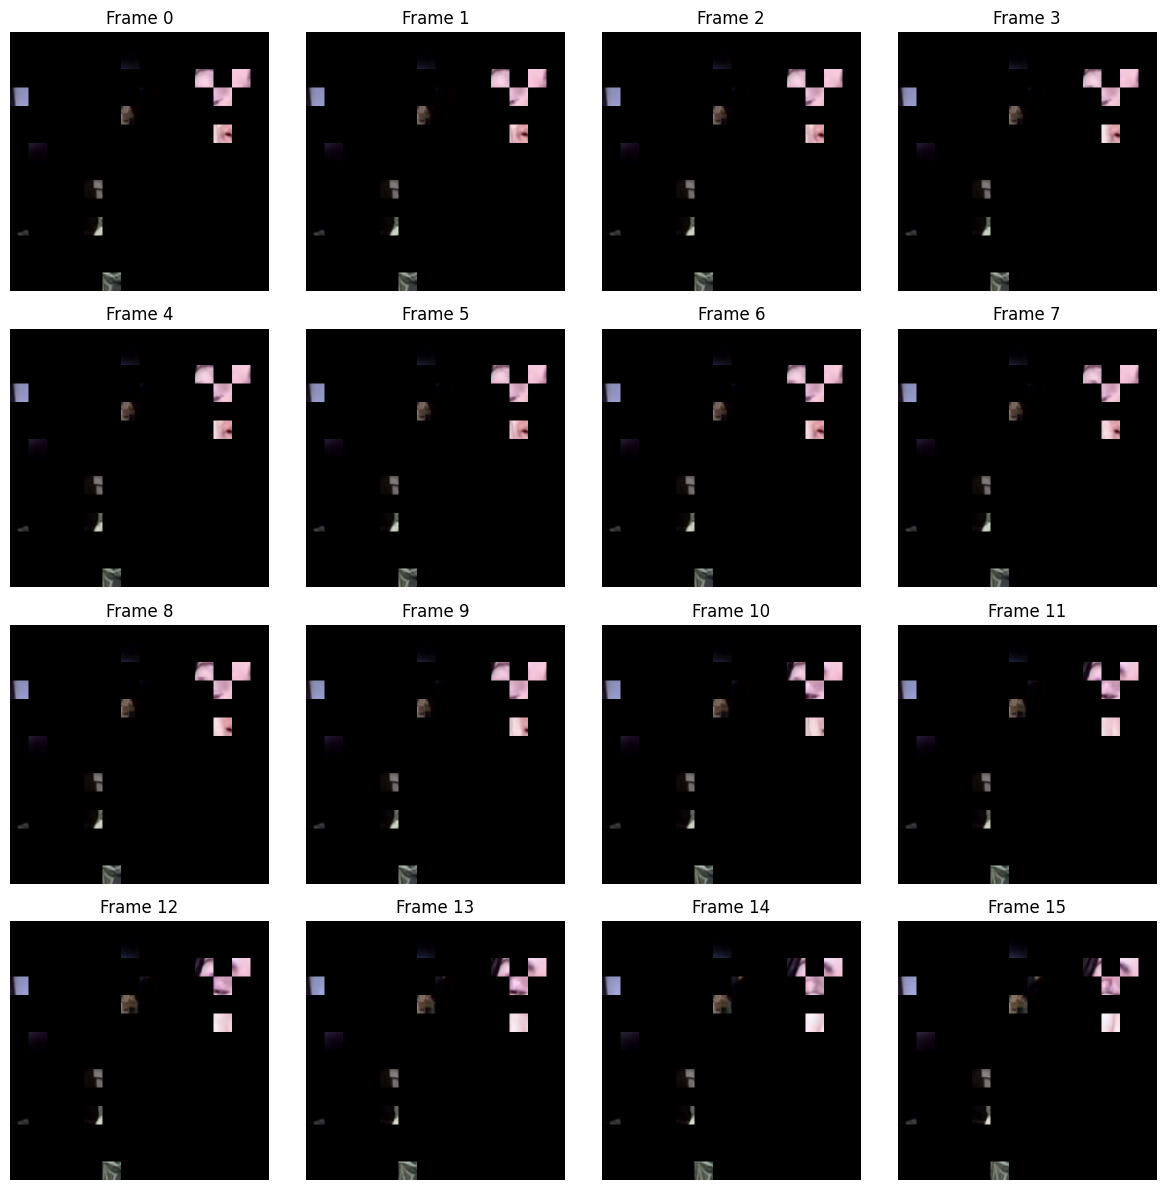

In [ ]:
#obtain masked clip:
masked_clip = visualize_masked_tokens(unnormalized_clip, mask_full)

# Convert each frame from tensor to numpy image
frames = [F.to_pil_image(frame) for frame in masked_clip]

# Plot them in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    ax.imshow(frames[i])
    ax.set_title(f"Frame {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()